### Imports

In [3]:
import cv2
import time

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from helpers.limbus_detection import detect_limbus
from helpers.misc import jiggle_circle, tighten_circle, repair_bbox
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


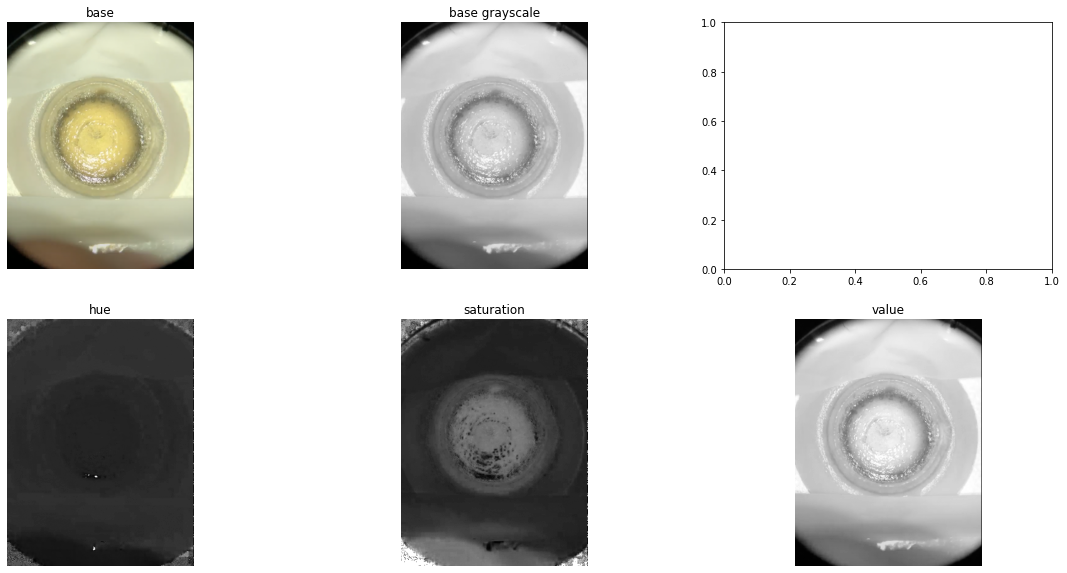

size: 335x445


In [4]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base2.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### Defining rhexis model constants

<table><tr>
    <td><img src="data/demonstrations/rhexis_full_diameter.png" width=200></td>
    <td><img src="data/demonstrations/rhexis_pupil_diameter.png" width=200></td>
</tr></table>

In [3]:
measurements = [664, 664, 654, 663, 652] # for diameter
RHEXIS_FULL_RADIUS = np.mean(measurements)/2

print('RHEXIS_FULL_RADIUS', RHEXIS_FULL_RADIUS)

RHEXIS_FULL_RADIUS 329.7


In [4]:
measurements = [431, 420, 430, 430, 429] # for diameter
RHEXIS_PUPIL_RADIUS = np.mean(measurements)/2

print('RHEXIS_PUPIL_RADIUS', RHEXIS_PUPIL_RADIUS)

RHEXIS_PUPIL_RADIUS 214.0


In [5]:
PUPIL_TO_FULL_RATIO = RHEXIS_PUPIL_RADIUS/ RHEXIS_FULL_RADIUS
print('pupil to full radia ratio', PUPIL_TO_FULL_RATIO)

pupil to full radia ratio 0.6490749165908402


### Trying to segment pupil color

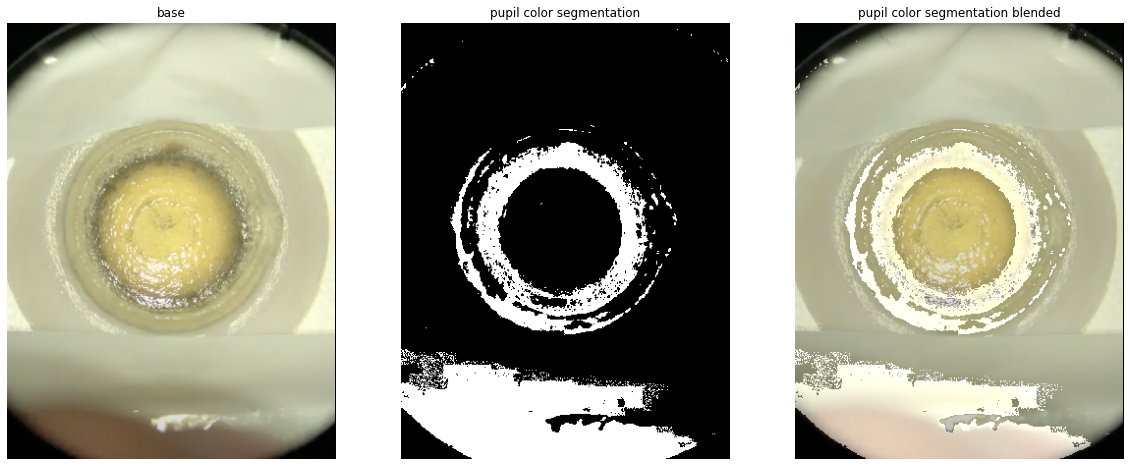

In [6]:
# old, prob too bright (default)
# pupil_color_lth = np.array([10, 40, 40])
# pupil_color_uth = np.array([30, 180, 180])

# slightly better; would require correction
# pupil_color_lth = np.array([16, 97, 193])
# pupil_color_uth = np.array([29, 153, 255])

# for the more defined outer ring; bad for zoomed in cases
# pupil_color_lth = np.array([15, 38, 140])
# pupil_color_uth = np.array([30, 127, 230])

# oldest; from initial tests; segments the whole of the eye
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)

base_blended = cv2.addWeighted(
    base_rgb,
    0.9,
    cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB),
    0.5,
    0.0
)

fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('pupil color segmentation')
plots[1].imshow(base_pupil_thres, cmap='gray')
plots[1].axis('off')

plots[2].set_title('pupil color segmentation blended')
plots[2].imshow(base_blended)
plots[2].axis('off')

plt.show()

### Displaying top ten detected circles

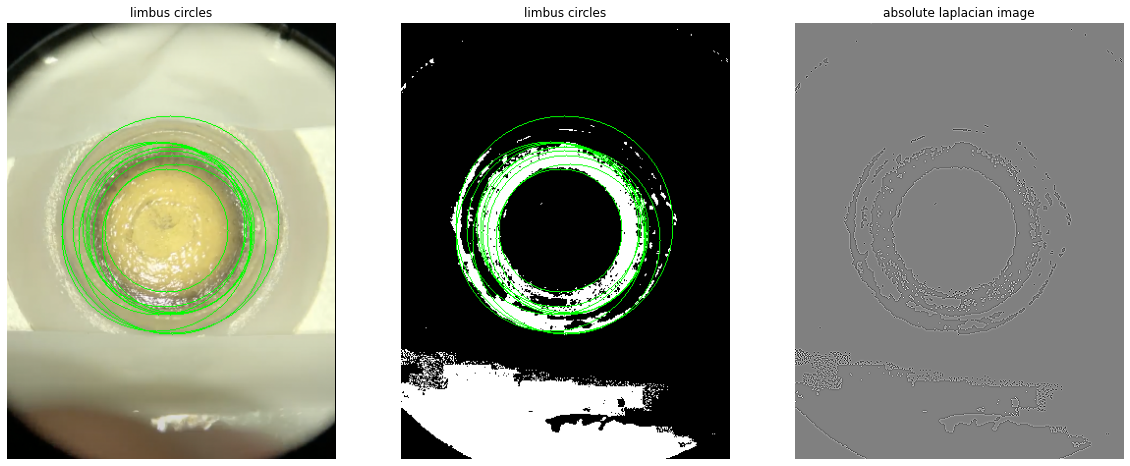

In [7]:
circles = detect_limbus(
    base_pupil_thres,
    return_all=True
)

base_copy = base_rgb.copy()
base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB)

for circle in circles[:10]:
    cv2.circle(base_copy, tuple(np.round(circle[:2]).astype('int')), 
               round(circle[2]), (0,255,0), thickness=1)
    cv2.circle(base_pupil_thres_copy, tuple(np.round(circle[:2]).astype('int')), 
               round(circle[2]), (0,255,0), thickness=1)

fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('limbus circles')
plots[1].imshow(base_pupil_thres_copy)
plots[1].axis('off')

plots[2].set_title('absolute laplacian image')
plots[2].imshow(cv2.Laplacian(base_pupil_thres, cv2.CV_16S), cmap=plt.cm.gray)
plots[2].axis('off')

plt.show()

### Displaying the best circle

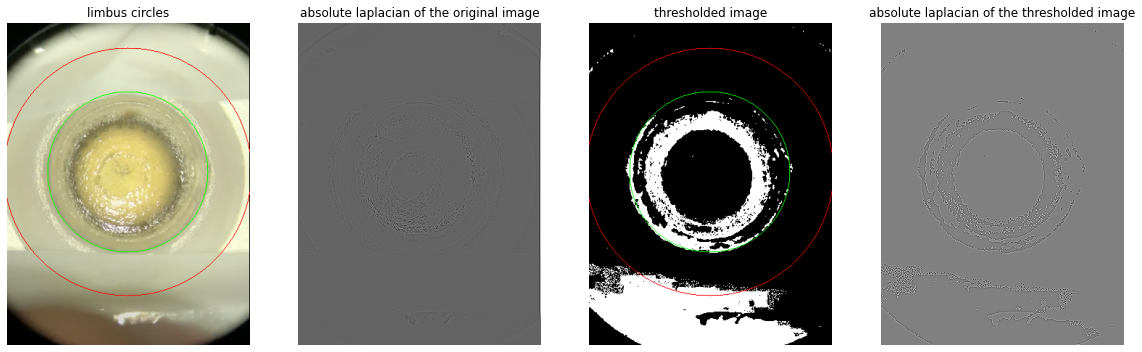

In [8]:
best_circle = detect_limbus(
    base_pupil_thres,
    validation='inout', 
    validation_mode='min'
)

base_copy = base_rgb.copy()
base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB)

cv2.circle(base_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]), (0,255,0), thickness=1)
cv2.circle(base_pupil_thres_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]), (0,255,0), thickness=1)

cv2.circle(base_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]/PUPIL_TO_FULL_RATIO), (255,0,0), thickness=1)
cv2.circle(base_pupil_thres_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]/PUPIL_TO_FULL_RATIO), (255,0,0), thickness=1)

fig, plots = plt.subplots(1, 4, figsize=(20,10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('absolute laplacian of the original image')
plots[1].imshow(cv2.Laplacian(base_gray, cv2.CV_16S), cmap=plt.cm.gray)
plots[1].axis('off')

plots[2].set_title('thresholded image')
plots[2].imshow(base_pupil_thres_copy)
plots[2].axis('off')

plots[3].set_title('absolute laplacian of the thresholded image')
plots[3].imshow(cv2.Laplacian(base_pupil_thres, cv2.CV_16S), cmap=plt.cm.gray)
plots[3].axis('off')

plt.show()

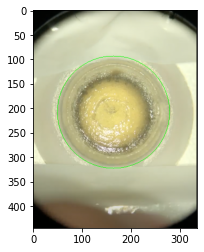

In [21]:
bc = detect_limbus(base_gray)
bcc = base_rgb.copy()
cv2.circle(bcc, tuple(np.round(bc[:2]).astype('int')), 
           round(bc[2]), (0,255,0), thickness=1)

plt.imshow(bcc)

In [2]:
cap = cv2.VideoCapture('/Users/mirek/Desktop/rhexis_input_long.mp4')
_, frame = cap.read()
cv2.imwrite('/Users/mirek/Desktop/blab.png', frame)

True

In [2]:
#
cap = cv2.VideoCapture('/Users/mirek/Desktop/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

    #     best_circle = detect_limbus(gray, validation='inout', validation_mode='max')
    circles = detect_limbus(gray, view_mask=view_mask, return_all=True)
    if (circles is not None):
        best_circle = None
        for circle in circles:
            if any(np.abs(circle - view_circle) > np.array([20, 20, 20])) and # similiarity of the detected circle
                    not (circle[2] > view_circle[2] and ):
                best_circle = circle
                break

        cv2.circle(frame, tuple(np.round(best_circle[:2]).astype('int')), 
               round(best_circle[2]), (0,255,0), thickness=1)

    cv2.imshow('detection', frame)
    cv2.imshow('view_mask', view_mask)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

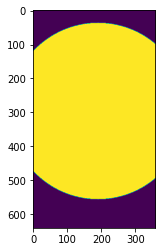

In [10]:
plt.imshow(get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))

In [9]:
view_mask = get_view_mask(base_gray)

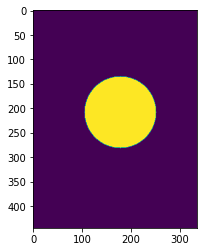

In [10]:
plt.imshow(view_mask)

In [11]:
def threshold_easy(l=0, u=255):
    plt.imshow(cv2.inRange(base_gray, l, u), cmap='gray')

In [15]:
def threshold_hsv(hl=0, sl=0, vl=0, hu=179, su=255, vu=255):
    plt.imshow(cv2.inRange(base_hsv, np.array([hl, sl, vl]), np.array([hu, su, vu])), cmap='gray')
    

In [18]:
widgets.interact(threshold_hsv, 
                 hl=(0,179,2), sl=(0,255,2), vl=(0,255,2),
                 hu=(0,179,2), su=(0,255,2), vu=(0,255,2),);

interactive(children=(IntSlider(value=0, description='hl', max=179, step=2), IntSlider(value=0, description='s…

In [14]:
widgets.interact(threshold_easy, l=(0,255,5), u=(0,255,5));

interactive(children=(IntSlider(value=0, description='l', max=255, step=5), IntSlider(value=255, description='…